In [1]:
import pandas as pd
import numpy as np
import itertools as it

import pickle as pcl

from scipy.spatial.distance import cdist

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from collections import Counter

# Get "Set2" colors from ColorBrewer (all colorbrewer scales: http://bl.ocks.org/mbostock/5577023)
#set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import MeanShift

In [2]:
from palettable.tableau import GreenOrange_12
from palettable.colorbrewer.sequential import YlGnBu_4, YlGnBu_5

cmap = GreenOrange_12.hex_colors
cmap_seq = YlGnBu_5.hex_colors

In [3]:
import hightolowz

In [4]:
redshift = '2p07'
redshift_str = '2.07'
selection = 'sfr'

In [5]:
dgal_random_r20 = pd.read_csv('data/planck1/dgal_%s_%s_r20_random.csv' % (selection, redshift))
dgal_random_r12p5 = pd.read_csv('data/planck1/dgal_%s_%s_r12.5_random.csv' % (selection, redshift))
dgal_random_r7p5 = pd.read_csv('data/planck1/dgal_%s_%s_r7.5_random.csv' % (selection, redshift))
dgal_random_r5 = pd.read_csv('data/planck1/dgal_%s_%s_r5_random.csv' % (selection, redshift))

In [6]:
dgal_random = pd.concat([dgal_random_r20,dgal_random_r12p5,dgal_random_r7p5,dgal_random_r5], axis=1)

### Probability distribution

For each sampled region if over 50% of the galaxies end up in a cluster sized object at $z=0$ we classify it as a protocluster. We then find the fraction of protoclusters for a range of binned overdensities

In [7]:
def aggregate_dgal(df, R, bins, lim_frac, lim_mass=1e4):
    """
    Aggregate galaxy overdensity information
    """

    agg_data = pd.DataFrame([bins]).T
    
    agg_data.columns = ['bins']

    agg_data['total'] = pd.DataFrame(np.histogram(df['delta_gal_%s' % str(R)], bins)[0])

    agg_data['frac'] =  pd.DataFrame(np.histogram(df[(df['max_fraction_%s' % str(R)] > lim_frac) \
                             & (df['max_fraction_mass_%s' % str(R)] > lim_mass)]['delta_gal_%s' % str(R)], bins)[0])

    agg_data['frac'] /= agg_data['total']

    agg_data['n_cluster_desc'] = pd.DataFrame(np.histogram(df[(df['max_fraction_%s' % str(R)] < lim_frac) \
                                    & (df['n_cluster_desc_%s' % str(R)] > 0)]['delta_gal_%s' % str(R)], bins)[0])

    agg_data['n_cluster_desc'] /= agg_data['total']

    return agg_data

Probability distribution and PDF of protocluster regions and non-protocluster regions

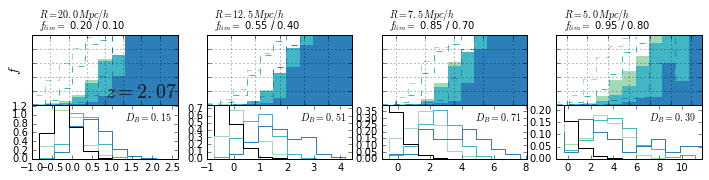

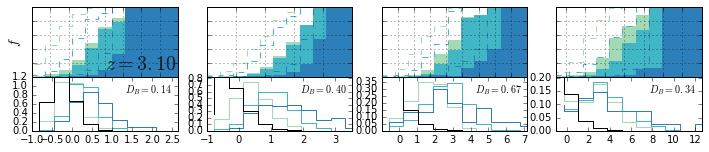

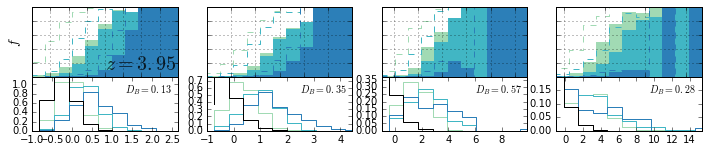

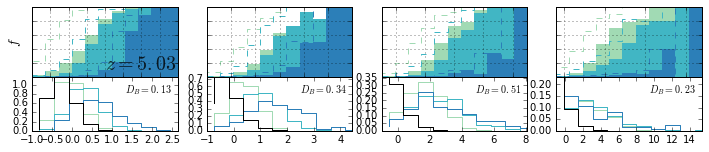

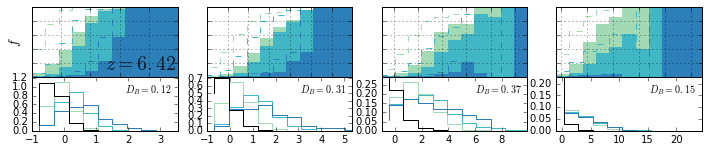

In [10]:
selection = 'sfr'

# for i, (redshift, redshift_str) in enumerate(zip(['3p95'],[3.95])):
for i, (redshift, redshift_str) in enumerate(zip(['2p07','3p10','3p95','5p03','6p42'],['2.07','3.10','3.95','5.03','6.42'])):
    
    dgal_random_r20 = pd.read_csv('data/planck1/dgal_%s_%s_r20_random.csv' % (selection, redshift))
    dgal_random_r12p5 = pd.read_csv('data/planck1/dgal_%s_%s_r12.5_random.csv' % (selection, redshift))
    dgal_random_r7p5 = pd.read_csv('data/planck1/dgal_%s_%s_r7.5_random.csv' % (selection, redshift))
    dgal_random_r5 = pd.read_csv('data/planck1/dgal_%s_%s_r5_random.csv' % (selection, redshift))
    
    dgal_random = pd.concat([dgal_random_r20,dgal_random_r12p5,dgal_random_r7p5,dgal_random_r5], axis=1)
    
    fig = plt.figure(figsize=(12,4))

    gs = gridspec.GridSpec(16, 4)

    gs.update(bottom = 0.57, top = 1, hspace=0)#, wspace=0)

    ax1 = fig.add_subplot(gs[:9,0])
    ax2 = fig.add_subplot(gs[:9,1])
    ax3 = fig.add_subplot(gs[:9,2])
    ax4 = fig.add_subplot(gs[:9,3])

    ax5 = fig.add_subplot(gs[9:16,0])
    ax6 = fig.add_subplot(gs[9:16,1])
    ax7 = fig.add_subplot(gs[9:16,2])
    ax8 = fig.add_subplot(gs[9:16,3])

    ax1.text(0.5, 0.1, "$z = %s$" % redshift_str, transform = ax1.transAxes, size=20, alpha=0.8)

    N = 12

    for R, ax_up, ax_dw, limiting_fraction, limiting_fraction_relaxed in zip(['20', '12.5', '7.5', '5'], 
                                                                             [ax1, ax2, ax3, ax4], 
                                                                             [ax5, ax6, ax7, ax8], 
                                                                             [0.20, 0.55, 0.85, 0.95],
                                                                             [0.10, 0.40, 0.70, 0.80]):


        dgal_max = max(dgal_random['delta_gal_%s'%R])   

        binLimits = np.linspace(-1, int(dgal_max)+1, N)

        lower_bin = binLimits[1] + (binLimits[0]-binLimits[1])/2 
        upper_bin = binLimits[-1] + (binLimits[0]-binLimits[1])/2

        bins = np.linspace(lower_bin, upper_bin, N-1)


        agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction, lim_mass=1e4)
        agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1

        ax_up.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], 
                color=cmap_seq[1], width=bins[1]-bins[0], edgecolor='none')

    #     bar = ax_up.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['n_cluster_desc'], bottom=agg_data['frac'], 
    #                     edgecolor=cmap_seq[1], width=bins[1]-bins[0], hatch='\\', color='none', lw=1.)

        agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction, lim_mass=3e4)
        agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1

        ax_up.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], 
                color=cmap_seq[2], width=bins[1]-bins[0], edgecolor='none')

        agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction, lim_mass=1e5)
        agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1

        ax_up.bar(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], 
                color=cmap_seq[3], width=bins[1]-bins[0], edgecolor='none')

        # relaxed limiting fraction
        agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction_relaxed, lim_mass=1e4)
        agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
        ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[1], linestyle='dashed')

        agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction_relaxed, lim_mass=3e4)
        agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
        ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[2], linestyle='dashed')

        agg_data = aggregate_dgal(dgal_random, R, bins, limiting_fraction_relaxed, lim_mass=1e5)
        agg_data.loc[np.isnan(agg_data['frac']), 'frac'] = 1
        ax_up.step(agg_data['bins'] - (bins[1]-bins[0])/2, agg_data['frac'], color=cmap_seq[3], linestyle='dashed')


        phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
                                  & (dgal_random['max_fraction_mass_%s'%R] >= 1e4) \
                                  & (dgal_random['max_fraction_mass_%s'%R] < 3e4)]['delta_gal_%s'%R],
                                  bins=binLimits, normed=True)
        ax_dw.step(bins, phiA, color=cmap_seq[1])
        max_phi = max(phiA)

        phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
                                  & (dgal_random['max_fraction_mass_%s'%R] >= 3e4) \
                                  & (dgal_random['max_fraction_mass_%s'%R] < 1e5)]['delta_gal_%s'%R],
                                  bins=binLimits, normed=True)
        ax_dw.step(bins, phiA, color=cmap_seq[2])
        max_phi = max(max_phi, max(phiA))

        phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
                                  & (dgal_random['max_fraction_mass_%s'%R] >= 1e5)]['delta_gal_%s'%R],
                                  bins=binLimits, normed=True)
        ax_dw.step(bins, phiA, color=cmap_seq[3])
        max_phi = max(max_phi, max(phiA))

        phiB, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] < limiting_fraction) \
                                  | (dgal_random['max_fraction_mass_%s'%R] < 1e4)]['delta_gal_%s'%R],
                                  bins=binLimits, normed=True)
        ax_dw.step(bins, phiB, color='black')

        phiA, mass = np.histogram(dgal_random[(dgal_random['max_fraction_%s'%R] >= limiting_fraction) \
                                  & (dgal_random['max_fraction_mass_%s'%R] >= 1e4)]['delta_gal_%s'%R],
                                  bins=binLimits, normed=True)

        DB, BC = hightolowz.bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))

        ax_dw.text(0.64, 0.7, "$D_{B} = %.2f$" % DB, transform = ax_dw.transAxes)
        
        if i == 0:
            ax_up.text(0.05, 1.25, "$R=%s \, Mpc/h$" % str(round(float(R), 1)), transform = ax_up.transAxes)
            ax_up.text(0.05, 1.1, "$f_{lim}=$ %.2f / %.2f" % (limiting_fraction, limiting_fraction_relaxed), transform = ax_up.transAxes)

        ax_up.grid()

        ax_up.set_xlim(min(binLimits), max(binLimits))

        ax_dw.set_ylim(0, max_phi + max_phi/10)
        ax_dw.set_xlim(min(bins) - (bins[1]-bins[0])/2, max(bins) - (bins[1]-bins[0])/2)


    ax1.set_xlabel('$\delta_{gal}$', size=14)
    ax1.set_ylabel('$f(\delta_{gal})$', size=14)

    ax1.set_ylabel('$f$', size=14)
    ax1.set_yticklabels(['','0.2','0.4','0.6','0.8','1.0'])


    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_yticklabels('')
        ax.set_xticklabels('')

    # plt.savefig('../papers/hightolowz/images/gal_od_prob_%s_%s.png' % (redshift, selection), bbox_inches='tight', dpi=300)
    

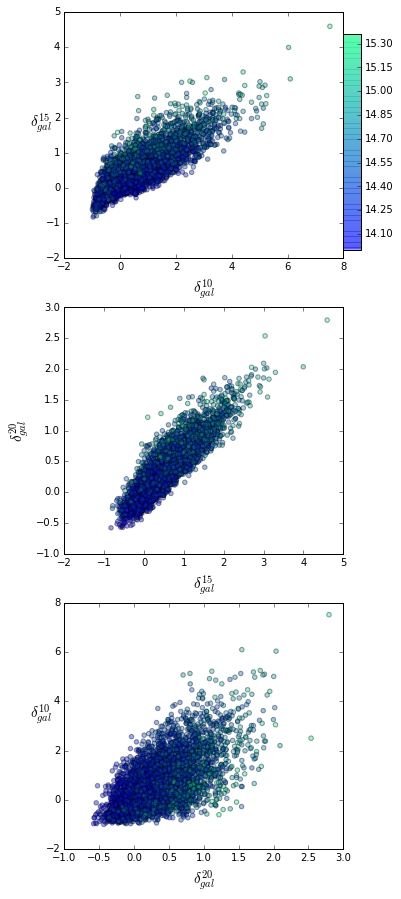

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(5,15))

limiting_fraction = 0.3

# plot 1
dgal_temp = dgal_random[(dgal_random['max_fraction_15'] > limiting_fraction) \
                        & (dgal_random['max_fraction_mass_15'] > 1e4)]

p = ax1.scatter(dgal_temp['delta_gal_10'], dgal_temp['delta_gal_15'], alpha=0.4, 
         c=np.log10(dgal_temp['max_fraction_mass_15']*1e10), cmap='winter')

#ax1.axvline(5.5, ls='--', c='grey')
#ax1.axhline(3.75, ls='--', c='grey')

#ax1.set_xlim(-1, 10)
#ax1.set_ylim(-1, 5.5)

ax1.set_xlabel('$\delta_{gal}^{10}$', size=15)
ax1.set_ylabel('$\delta_{gal}^{15}$', rotation=0, size=15)

cax = fig.add_axes([0.9, 0.68, 0.05, 0.2])
fig.colorbar(p, cax=cax, orientation='vertical')


# plot 2

p = ax2.scatter(dgal_temp['delta_gal_15'], dgal_temp['delta_gal_20'], alpha=0.4, 
         c=np.log10(dgal_temp['max_fraction_mass_15']*1e10), cmap='winter')


#ax2.axvline(3.75, ls='--', c='grey')
#ax2.axhline(3.25, ls='--', c='grey')

#ax2.set_xlim(-1, 5.5)
#ax2.set_ylim(-1, 4.5)

ax2.set_xlabel('$\delta_{gal}^{15}$', rotation=0, size=15)
ax2.set_ylabel('$\delta_{gal}^{20}$', size=15)

# cax = fig.add_axes([0.9, 0.48, 0.05, 0.2])
# fig.colorbar(p, cax=cax, orientation='vertical')


# plot 3

p = ax3.scatter(dgal_temp['delta_gal_20'], dgal_temp['delta_gal_10'], alpha=0.4, 
         c=np.log10(dgal_temp['max_fraction_mass_15']*1e10), cmap='winter')

#ax3.axvline(3.25, ls='--', c='grey')
#ax3.axhline(5.5, ls='--', c='grey')

#ax3.set_xlim(-1, 4.5)
#ax3.set_ylim(-1, 9)

ax3.set_xlabel('$\delta_{gal}^{20}$', size=15)
ax3.set_ylabel('$\delta_{gal}^{10}$', rotation=0, size=15)

# cax = fig.add_axes([0.9, 0.68, 0.05, 0.2])
# fig.colorbar(p, cax=cax, orientation='vertical')


# print sum(dgal_temp['delta_gal_10'] > 6)
# print sum(dgal_temp['delta_gal_15'] > 3.5)

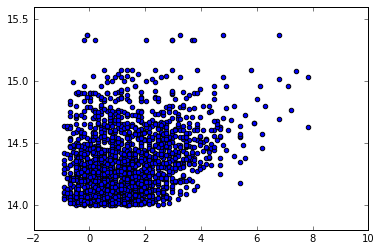

In [152]:
dgal_random = dgal_random_r10

plt.scatter(dgal_random[(dgal_random['max_fraction'] > limiting_fraction) & (dgal_random['max_fraction_mass'] > 1e4)]['delta_gal'],
            np.log10(dgal_random[(dgal_random['max_fraction'] > limiting_fraction) & (dgal_random['max_fraction_mass'] > 1e4)]['max_fraction_mass']*1e10))